# 0. Background - Commodities markets - Tasks

We are interested in **natural gas storage contracts**. The goal is to price the contract using historical data and an estimate of the future gas price at any date. The latter obtained by extrapolating the data available from external feeds. 


### Setup

We are given a monthly snapshot of prices from a market data provider. The data consists of the market price of natural gas delivered at the end of each calendar month.

We want to use this data to perform two tasks. The first is to come up with a function that takes any given date in the time frame of our data, and returns the price on that date. Recall that we initially only know the market price at the end of each calendar month. The second task is a forecasting problem. Given a date in the future (no further than a year from the last date in the data), we want a function that returns an estimated market price of natural gas on that date. So, we have to perform interpolation for the former and extrapolation for the latter.

### Expectations
Natural gas prices are expected to show seasonality because of the effects of annual temperature variation on natural gas supply and demand. 

---

# 1. Prep

Load the data

In [45]:
import pandas as pd
import numpy as np 

In [46]:
nat_gas_df = pd.read_csv('./01-nat_gas_historical_data.csv')
nat_gas_df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [47]:
nat_gas_df.shape

(48, 2)

The data has two columns: last day of the month and the price. The price is the market price of natural gas delivered at the end of each month. 

In [48]:
nat_gas_df.dtypes

Dates      object
Prices    float64
dtype: object

In [49]:
nat_gas_df['Dates'] = pd.to_datetime(nat_gas_df['Dates'])
nat_gas_df['Dates'].head()

/var/folders/h0/722z94dd3fb0pfv4wg3qmdkh0000gn/T/ipykernel_77216/651607428.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nat_gas_df['Dates'] = pd.to_datetime(nat_gas_df['Dates'])


0   2020-10-31
1   2020-11-30
2   2020-12-31
3   2021-01-31
4   2021-02-28
Name: Dates, dtype: datetime64[ns]

In [50]:
nat_gas_df['Dates'].min(), nat_gas_df['Dates'].max()

(Timestamp('2020-10-31 00:00:00'), Timestamp('2024-09-30 00:00:00'))

In [51]:
nat_gas_df['Dates'].min()-nat_gas_df['Dates'].max()

Timedelta('-1430 days +00:00:00')

In [52]:
nat_gas_df.dtypes

Dates     datetime64[ns]
Prices           float64
dtype: object

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
df = nat_gas_df.copy()
df.index = df['Dates']
del df['Dates']
df.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


## 2 Exploratory Data Analysis (Time series analysis)

Before we forecast, we will do a time series analysis (to study the history). When we train a model later, the principle will be

> If you have clear trend and seasonality in your time series, then model these components, remove them from observations, then train models on the residuals.
>Statistical time series methods and even modern machine learning methods will benefit from the clearer signal in the data.

<Axes: xlabel='Dates'>

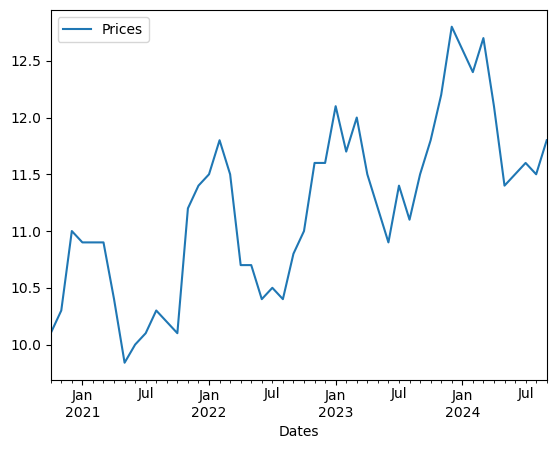

In [55]:
df.plot()

There is a clear trend and seasonality. 

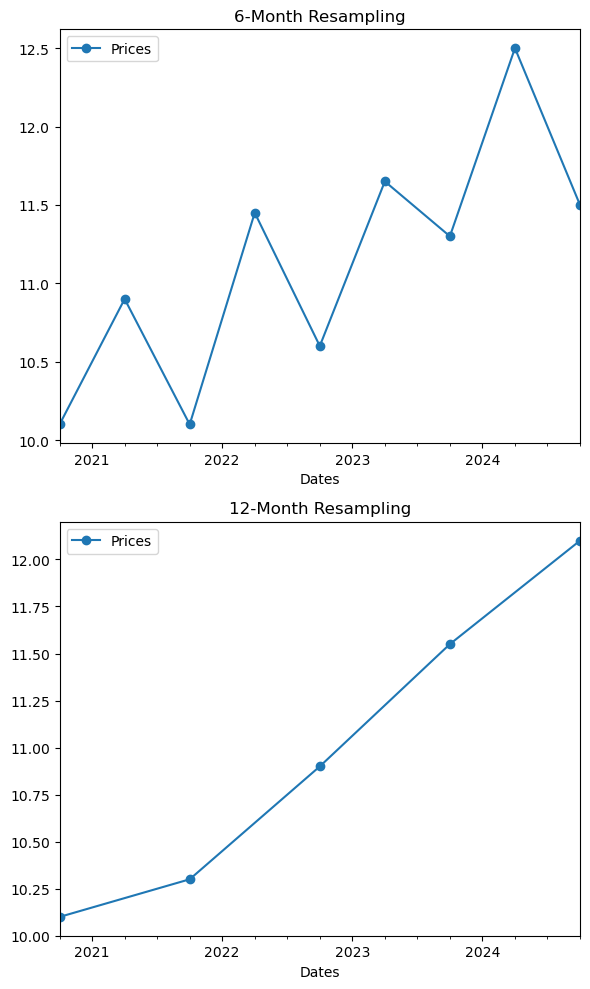

In [56]:
#This is to discover seasonality

fig, axes = plt.subplots(2, 1, figsize=(6,10))

df.resample('6M').median().plot(style='-o', ax=axes[0])
axes[0].set_title('6-Month Resampling')

df.resample('12M').median().plot(style='-o', ax=axes[1])
axes[1].set_title('12-Month Resampling')

plt.tight_layout()
plt.show()

At this point, we want to identify the trend and seasonality, and determine whether they are additive or multiplicative. We could manually perform differencing, subtracting rolling mean, etc. But there is a nice `statsmodel` function called `seasonal_decompose` to decompose our time series into the trend and seasonal components.

In [57]:
import statsmodels.api as sm 

The function `seasonal_decompose` requires that we specify the whether the seasonality is multiplicative or additive. We will do both and conclude which one it really is after seeing the results.

Text(0.5, 1.0, 'ADDITIVE')

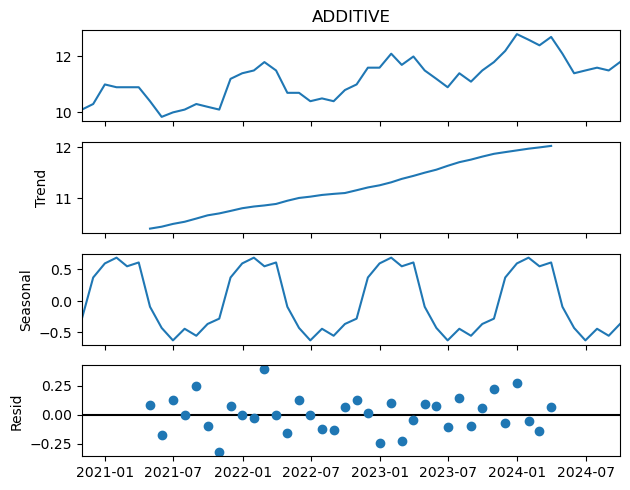

In [58]:
fig = sm.tsa.seasonal_decompose(df, model='ADDITIVE').plot() 
#no need for period= because a Pandas Series object is provided
fig.axes[0].set_title("ADDITIVE")


Here we see variance in the residual. What if we assume it's multiplicative?

Text(0.5, 1.0, 'MULTIPLICATIVE')

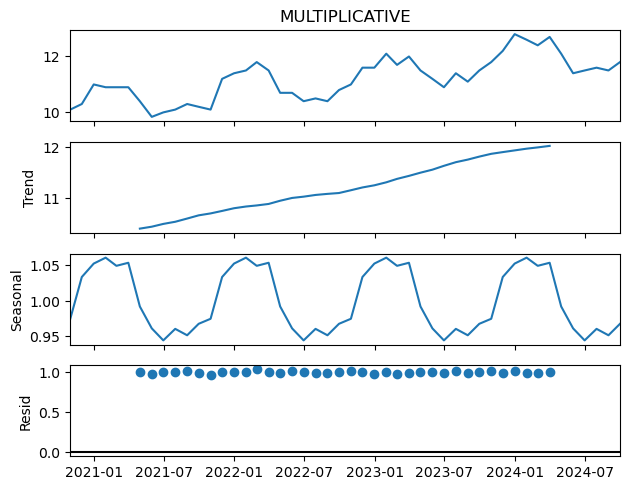

In [59]:
fig = sm.tsa.seasonal_decompose(df, model='multiplicative').plot() 
#no need for period= because a Pandas Series object is provided
fig.axes[0].set_title("MULTIPLICATIVE")


As we can see, the residual $R = y/(T\cdot S)$ is constantly around 1, which is a clear indication that the seasonality is multiplicative. The trend is obviously additive.

---

# 3. Price at any date --- Interpolation

We want a historical price function `pricehist`

In [60]:
start_date = df.index.min()
end_date = df.index.max()
print(df.index.min(), df.index.max())

2020-10-31 00:00:00 2024-09-30 00:00:00


<Axes: xlabel='Dates'>

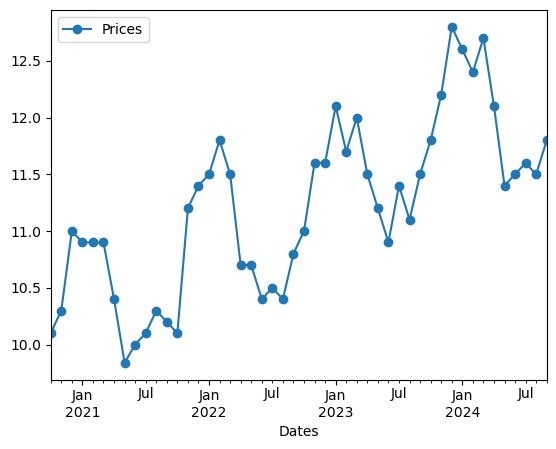

In [61]:
df.plot(style='-o')

In [62]:
upsampled = df.resample('D').asfreq()
upsampled.head(31)


,Prices
Dates,
2020-10-31,10.1
2020-11-01,NaN
2020-11-02,NaN
2020-11-03,NaN
2020-11-04,NaN
2020-11-05,NaN
2020-11-06,NaN
2020-11-07,NaN
2020-11-08,NaN


<Axes: xlabel='Dates'>

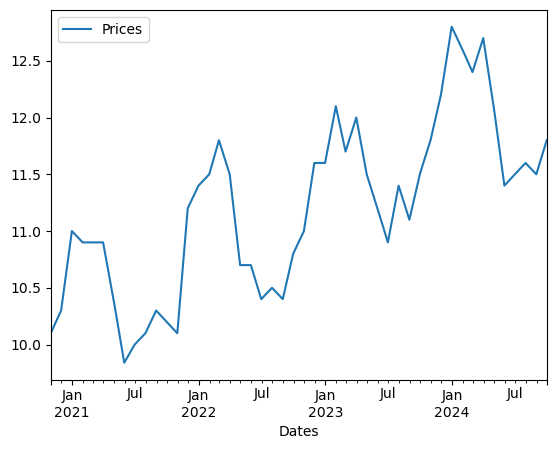

In [63]:
interpolated = upsampled.interpolate(method='linear')
interpolated.plot()

In [64]:
interpolated.head()

,Prices
Dates,
2020-10-31,10.100000
2020-11-01,10.106667
2020-11-02,10.113333
2020-11-03,10.120000
2020-11-04,10.126667


In [65]:
# Price history function. Takes date
def pricehist(date) -> int:
    date = pd.to_datetime(date)
    if not (start_date <= date) & (date <=end_date):
        print('Date out of range or give date as a string')
    else:
        return interpolated.loc[date, 'Prices']

In [66]:
pricehist('July 20, 2022')

10.464516129032258

---

# 3. Forecasting

Recall that our time series is multiplicative with trend and seasonality. It has error of 1. For this reason, we will use the **Holt-Winters Exponential Smoothing.**

In [67]:
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error as rmse

In [68]:
# Split data into train and test
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[:t_idx], data[t_idx: ]
    print(f'train: {len(train)}, test: {len(test)}')
    return train, test

In [69]:
# Split at 85% to 15%
test_split = 0.15
df_train, df_test = split_data(df, test_split)

train = df_train.values.ravel()
y = df_test.values.ravel()

# Fit the Holt-Winters model with the hyperparameters determined from earlier.
'''The tuning can be automated to pick the best. But we will just do RMSE, plot the prediction, and eye-ball it
There is not many combinations for trend, seasonal: mul vs add, and the seasonal_periods are obviously 12'''

exp = ExponentialSmoothing(
    train,
    trend='add',
    seasonal = 'mul',
    seasonal_periods = 12
)
model = exp.fit(
    use_brute=True,
    optimized=True
)

# Make a prediction 
y_hat = model.forecast(len(y))
print(rmse(y,y_hat))

train: 41, test: 7
0.01890203183326777


Now we plot the prediction:

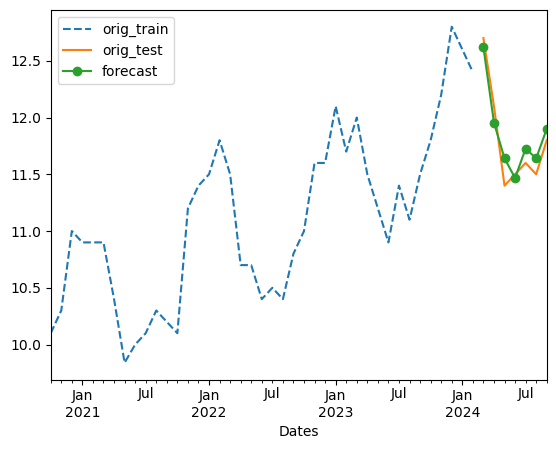

In [70]:
forecast = pd.DataFrame(y_hat, index = df_test.index)
ax = df_train.plot(style = '--')
df_test.plot(ax = ax)
forecast.plot(ax=ax, style = '-o')
ax.legend(['orig_train', 'orig_test', 'forecast'])
plt.show()

In [71]:
nrmse = rmse(y,y_hat)/(y.max()-y.min())
nrmse

0.014540024487129067

Great!

Now, we extrapolate this for the following year, at a daily frequency.

In [72]:
df.index.max()

Timestamp('2024-09-30 00:00:00')

In [73]:
y_hat_long = model.forecast(20)
y_hat_long 

array([12.61920007, 11.95548172, 11.64104226, 11.46740369, 11.72644771,
       11.64006404, 11.90064397, 12.10047865, 12.74043381, 13.15150429,
       13.23041372, 13.13163886, 13.19592019, 12.4997957 , 12.1690371 ,
       11.98556443, 12.25432578, 12.16209515, 12.43237428, 12.6391321 ])

In [74]:
y_hat

array([12.61920007, 11.95548172, 11.64104226, 11.46740369, 11.72644771,
       11.64006404, 11.90064397])

In [75]:
y_hat_long[7:] #This starts at 10/30/24 and ends at (monthly) 10/30/25

array([12.10047865, 12.74043381, 13.15150429, 13.23041372, 13.13163886,
       13.19592019, 12.4997957 , 12.1690371 , 11.98556443, 12.25432578,
       12.16209515, 12.43237428, 12.6391321 ])

In [76]:
xtp_start = df.index.max() #Extrapolation start
xtp_index = pd.date_range(
    start = xtp_start,
    end= xtp_start + pd.DateOffset(months=12),
    freq='M'
) 

xtp_year = pd.Series(data=y_hat_long[7:], index=xtp_index)

In [77]:
xtp_df = pd.DataFrame({'Prices': xtp_year})

# Concatenate the existing DataFrame with the time series DataFrame
df_pyear = pd.concat([df, xtp_df])
df_pyear.tail()

,Prices
2025-05-31,11.985564
2025-06-30,12.254326
2025-07-31,12.162095
2025-08-31,12.432374
2025-09-30,12.639132


In [78]:
df_pyear.shape

(61, 1)

We expect `(60,1)`. But it appears there is a duplicated index (from concat). We have to remove it.

In [79]:
duplicated_indices = df_pyear.index.duplicated()
df_pyear = df_pyear[~duplicated_indices]
df_pyear.shape

(60, 1)

<Axes: >

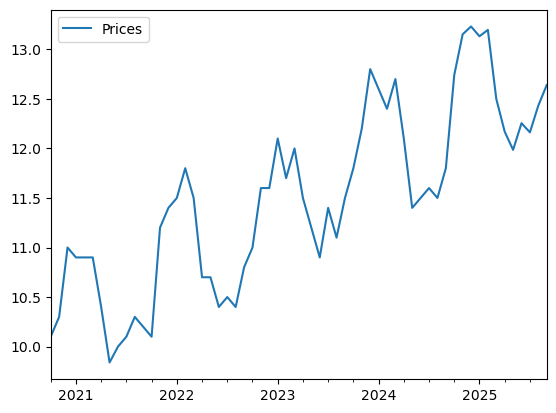

In [80]:
df_pyear.plot()

Now, we interpolate between the dates just like what we did in the previous section.

In [81]:
upsampled_pyear = df_pyear.resample('D').asfreq() #Fill the days in between the end of the months with NaN
upsampled_pyear.tail(31)


,Prices
2025-08-31,12.432374
2025-09-01,NaN
2025-09-02,NaN
2025-09-03,NaN
2025-09-04,NaN
2025-09-05,NaN
2025-09-06,NaN
2025-09-07,NaN
2025-09-08,NaN
2025-09-09,NaN


<Axes: >

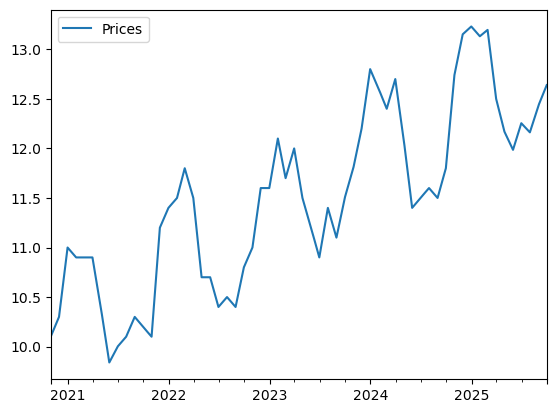

In [82]:
# Now we interpolate
interpolated_pyear = upsampled_pyear.interpolate(method='linear')
interpolated_pyear.plot()

Finally, we will define a forecasting function. It will take a date between Sep. 30, 2024 and Sep. 30, 2025 and return an estimate of the market price of natural gas.

In [83]:
# Price forecast function. Takes date
last_date = df_pyear.index.max()
def priceforecast(date) -> int:
    date = pd.to_datetime(date)
    if (start_date <= date) & (date <=end_date):
        return pricehist(date)
    elif (date <= last_date):
        return interpolated_pyear.loc[date, 'Prices']
    elif (date >last_date):
        print("Date out of range!")

In [84]:
priceforecast('January 3rd, 2026')

Date out of range!


In [85]:
priceforecast('Jan 4, 2025')

13.217668577827496

<Axes: >

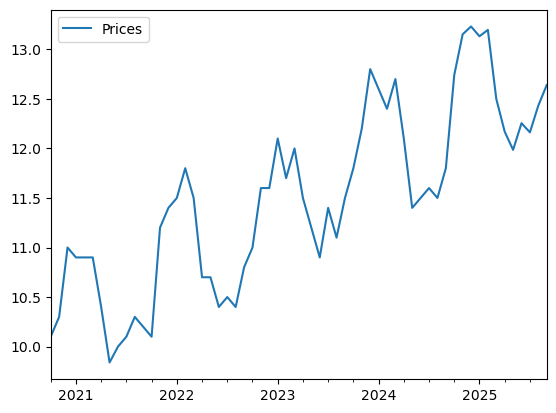

In [86]:
df_pyear.plot()

# Observations

* The market price of natural gas is seasonal.
* It is also exhibiting a trend of increase (at an almost linear rate)
* The price of natural gas is increases in the winter months and drops in the summer. This has to do with the seasonality of the weather and its impact on the supply and demand for heating among other things
* The storage cost of natural gas also plays a role in the price change; indirectly because of the supply and demand disruption. Directly because, for example, in regions where natural gas production is impacted by freezing temperatures or heavy snowfall, production may be affected during winter months.

In [87]:
interpolated_pyear.shape

(1796, 1)

In [88]:
interpolated_pyear.to_csv('./task_2/exported_prices_nat_gas.csv')